# Analyze test performance

Run basic analysis of test performance and calculate statistics that are relevant for other analyses.

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from nireact import task

fig_dir = '/Users/morton/Dropbox/work/mistr/figs2/plots'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Load test data

In [2]:
data_dir = '/Users/morton/work/mistr'
data = task.read_test_all_subj(data_dir)
data.head()

,trial,triad,train_type,trial_type,test_type,correct,rt,response,test,subject,subj_id,subj_idx
0,1,7,2,3,2,0,7.271,0,AC,2,mistr_02,0
1,2,12,2,3,2,1,3.852,1,AC,2,mistr_02,0
2,3,3,1,3,2,1,2.664,1,AC,2,mistr_02,0
3,4,8,2,3,2,1,2.182,1,AC,2,mistr_02,0
4,5,4,1,3,2,1,3.944,1,AC,2,mistr_02,0


## Analyze accuracy

Calculate summary statistics and plots by test type. Test for accuracy differences between tests.

In [3]:
# accuracy summary statistics
test_names = ['AB', 'BC', 'AC']
acc = data.groupby(['test', 'subject'], as_index=False).mean()
acc_mean = acc.pivot(index='subject', columns='test', values='correct')
acc_mean = acc_mean.reindex(test_names, axis=1)
acc_mean.agg([np.mean, task.sem])

,AB,BC,AC
mean,0.958333,0.974359,0.903846
sem,0.191667,0.194872,0.180769


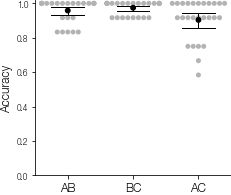

In [11]:
# plot accuracy for each subject
fig, ax = plt.subplots(figsize=(3.5, 3));
g1 = sns.swarmplot(x='test', y='correct', data=acc, 
                   order=test_names, color=[.7, .7, .7]);
g2 = sns.pointplot(x='test', y='correct', data=acc,
                   order=test_names, color='k', ci=95, join=False, capsize=.5)
ax.set_ylabel('Accuracy')
ax.set_xlabel(None);
ax.set_ylim(0, 1.02)
ax.tick_params(axis='x', labelsize='large')
plt.setp(g2.lines, zorder=100, linewidth=1)
plt.setp(g2.collections, zorder=100);

fig.savefig(os.path.join(fig_dir, 'test_accuracy.pdf'))

In [5]:
# compare test accuracy
df = acc_mean.shape[0] - 1
comp = [('AB', 'BC'), ('AB', 'AC'), ('BC', 'AC')]
for c in comp:
    x = [acc_mean.loc[:, var].to_numpy() for var in c]
    t, p = st.ttest_ind(x[0], x[1])
    print(f'{c[0]} - {c[1]}: t({df})={t:.2f}, p={p:g}')

AB - BC: t(25)=-1.04, p=0.301328
AB - AC: t(25)=2.02, p=0.0484114
BC - AC: t(25)=2.86, p=0.00617733


## Number of trials for neural analysis

The permutation test for cross-triad organization depends on swapping A and C items within triad, so that the number of permutations possible is 2 ** n * 2 ** m, where n and m are the number of triads responded to correctly on the inference test for the blocked and intermixed trials, respectively.

In [6]:
# range for the number of correct trials available in each training condition
acc_train = data.groupby(['train_type', 'trial_type', 'subject'], as_index=False).sum()
ac_count = acc_train.loc[acc_train.trial_type == 3]
n = ac_count.pivot(index='subject', columns='train_type', values='correct')
n.agg(['min', 'max'])

,1,2
min,2,3
max,6,6


In [7]:
# number of permutations possible for cross-triad analysis
(2 ** n.sum(1)).agg(['min', 'max'])

min     128
max    4096
dtype: int64

## Analyze response time

In [8]:
# get mean rt for correct trials only
corr = data.loc[data.correct == 1]
rt_corr = corr.groupby(['test', 'subject'], as_index=False).mean()
rt_mean = rt_corr.pivot(index='subject', columns='test', values='rt')
rt_mean = rt_mean.reindex(test_names, axis=1)
rt_mean.agg([np.mean, task.sem])

,AB,BC,AC
mean,2.454980,2.639359,4.829247
sem,0.490996,0.527872,0.965849


In [47]:
dm = corr.groupby(['train_type', 'test', 'subject']).mean()
rt_diff = (dm.loc[1] - dm.loc[2]).reset_index()
m = (dm.loc[1] - dm.loc[2])
mm = (m.loc['AB'] + m.loc['BC']) / 2
direct = mm.rt.values
indirect = m.loc['AC'].rt.values
t, p = st.ttest_ind(direct - indirect, np.zeros(direct.shape))
print(t)
print(p)

0.5953057437549008
0.554324104966208


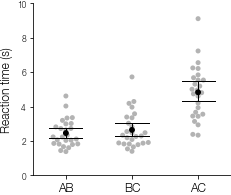

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 3));
g1 = sns.swarmplot(x='test', y='rt', data=rt_corr, order=test_names, 
                   color=[.7, .7, .7]);
g2 = sns.pointplot(x='test', y='rt', data=rt_corr, order=test_names,
                   color='k', ci=95, join=False, capsize=.5)
ax.set_ylabel('Reaction time (s)')
ax.set_xlabel(None);
ax.set_ylim(0, 10)
ax.tick_params(axis='x', labelsize='large')
plt.setp(g2.lines, zorder=100, linewidth=1)
plt.setp(g2.collections, zorder=100);

fig.savefig(os.path.join(fig_dir, 'test_rt.pdf'))

In [10]:
# compare test RT
df = rt_mean.shape[0] - 1
comp = [('AB', 'BC'), ('AB', 'AC'), ('BC', 'AC')]
for c in comp:
    x = [rt_mean.loc[:, var].to_numpy() for var in c]
    t, p = st.ttest_ind(x[0], x[1])
    print(f'{c[0]} - {c[1]}: t({df})={t:.2f}, p={p:g}')

AB - BC: t(25)=-0.72, p=0.476807
AB - AC: t(25)=-6.90, p=8.60972e-09
BC - AC: t(25)=-5.96, p=2.5663e-07


In [50]:
direct = (rt_mean.AB + rt_mean.BC) / 2
indirect = rt_mean.AC
t, p = st.ttest_ind(direct, indirect)
print(f't(25)={t:.2f}, p={p:g}')

t(25)=-6.63, p=2.24024e-08
